# ARIMA Modeling of GDP (Univariate Forecasting)

## Background

This notebook forms part of a broader econometric study examining the relationship between GDP and key macroeconomic indicators including:

- Foreign Direct Investment (FDI)
- Inflation
- Unemployment
- Government Consumption Expenditure (GCE)

## Objective

The objective of this analysis is to:

1. Examine the time-series properties of GDP.
2. Test for stationarity.
3. Identify an appropriate ARIMA model.
4. Generate short-term GDP forecasts.

This allows us to understand whether GDP exhibits predictable temporal dynamics independent of other macroeconomic variables.

## Purpose
This notebook builds a **univariate** ARIMA model for India’s GDP (current USD, billions) and produces out-of-sample forecasts.

The workflow follows the Box–Jenkins approach:
1. Load and structure the GDP time series
2. Visual inspection
3. Stationarity testing (ADF)
4. Transformations to achieve stationarity (log / differencing)
5. Identification using ACF/PACF
6. Model selection and estimation (ARIMA)
7. Validation with a simple holdout split
8. Residual diagnostics and forecasting

Note: This notebook focuses only on GDP’s internal dynamics (univariate). Multivariate relationships (e.g., VAR / Granger) are handled in the separate notebook.


## 0. Setup
I import the required libraries and define a small set of helper functions used throughout the analysis.

In [1]:
# Core
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Stats / time-series
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error


## 1. Load data and create a GDP time series

The dataset is stored in the repository under `data/`.  I convert the `Years` column into a proper datetime index and isolate GDP.

In [ ]:
df = pd.read_csv("..\\data\\gdp data.csv")

# Create a datetime index (annual frequency)
df["Years"] = pd.to_datetime(df["Years"].astype(int).astype(str), format="%Y")
df = df.sort_values("Years").set_index("Years")

gdp_col = "GDP (current USD in billions)"
gdp = df[gdp_col].astype(float)

df[[gdp_col]].head()

,GDP (current USD in billions)
Years,
1960-01-01,37.03
1961-01-01,39.23
1962-01-01,42.16
1963-01-01,48.42
1964-01-01,56.48


## 2. Visual inspection

GDP typically exhibits trend growth over long horizons. A visible trend is a common indicator of non-stationarity.

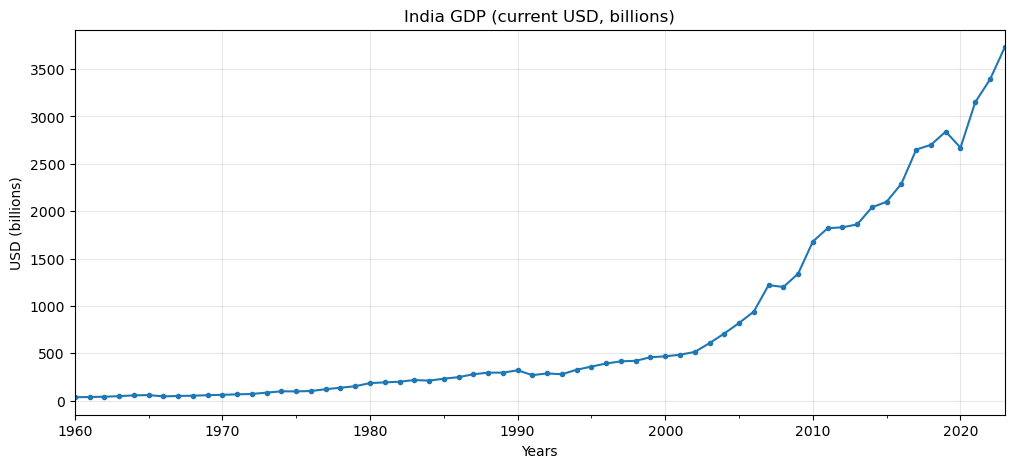

In [9]:
plt.figure(figsize=(12,5))
gdp.plot(marker=".")
plt.title("India GDP (current USD, billions)")
plt.ylabel("USD (billions)")
plt.grid(alpha=0.3)
plt.show()

### Interpretation: GDP in Levels

The GDP series exhibits a pronounced upward trend over the sample period (1960–2023), with accelerated growth particularly after the early 2000s.

This strong deterministic and stochastic trend suggests that GDP in levels is non-stationary. The increasing variance over time further supports the presence of a unit root process.

Given this visual evidence, formal stationarity testing is required.

## 3. Stationarity testing (ADF)

ARIMA requires a stationary series. I use the Augmented Dickey–Fuller test:

- **H0:** unit root (non-stationary)  
- **H1:** stationary

If p-value > 0.05, we typically difference (and/or transform) the series.

In [10]:
def adf_report(series: pd.Series, name: str = "series"):
    series = series.dropna()
    stat, pvalue, lags, nobs, crit, _ = adfuller(series, autolag="AIC")
    out = {
        "series": name,
        "adf_stat": stat,
        "p_value": pvalue,
        "lags": lags,
        "n_obs": nobs,
        "crit_1%": crit["1%"],
        "crit_5%": crit["5%"],
        "crit_10%": crit["10%"],
    }
    return pd.Series(out)

adf_report(gdp, "GDP (level)")

series      GDP (level)
adf_stat       2.824557
p_value             1.0
lags                 10
n_obs                53
crit_1%       -3.560242
crit_5%        -2.91785
crit_10%      -2.596796
dtype: object

### ADF Test – GDP (Level)

ADF Statistic: 2.82  
p-value: 1.00  

The p-value is substantially greater than 0.05, meaning we fail to reject the null hypothesis of a unit root.

Conclusion:
GDP in levels is non-stationary.

This result is consistent with macroeconomic theory, as aggregate output typically follows a persistent stochastic trend.

## 4. Transformations to achieve stationarity

We test common transformations:
- **log(GDP)** to stabilize variance
- **first difference of log(GDP)** to remove trend (typical for macro series)

We choose a transformation that yields stationarity and is economically interpretable.

In [11]:
gdp_log = np.log(gdp).replace([np.inf, -np.inf], np.nan).dropna()
gdp_log_diff = gdp_log.diff().dropna()

pd.concat(
    [adf_report(gdp_log, "log(GDP)"),
     adf_report(gdp_log_diff, "diff(log(GDP))")],
    axis=1
)

,0,1
series,log(GDP),diff(log(GDP))
adf_stat,0.234189,-7.577564
p_value,0.974115,0.0
lags,0,0
n_obs,63,62
crit_1%,-3.538695,-3.540523
crit_5%,-2.908645,-2.909427
crit_10%,-2.591897,-2.592314


### ADF Test – Log Transformations

The log transformation alone does not induce stationarity (p ≈ 0.97).

However, the first difference of log(GDP):

ADF Statistic ≈ -7.58  
p-value ≈ 0.00  

This strongly rejects the null hypothesis of a unit root.

Conclusion:
The growth rate of GDP (i.e., Δlog(GDP)) is stationary.

This implies GDP is integrated of order one in logs, consistent with standard macroeconomic time-series behavior.

## 5. Identification via ACF/PACF

After stationarity is achieved, we use ACF/PACF to guide AR (p) and MA (q) orders.

- PACF “cutoff” suggests AR order  
- ACF “cutoff” suggests MA order  
- Slow decay often suggests mixed ARMA components

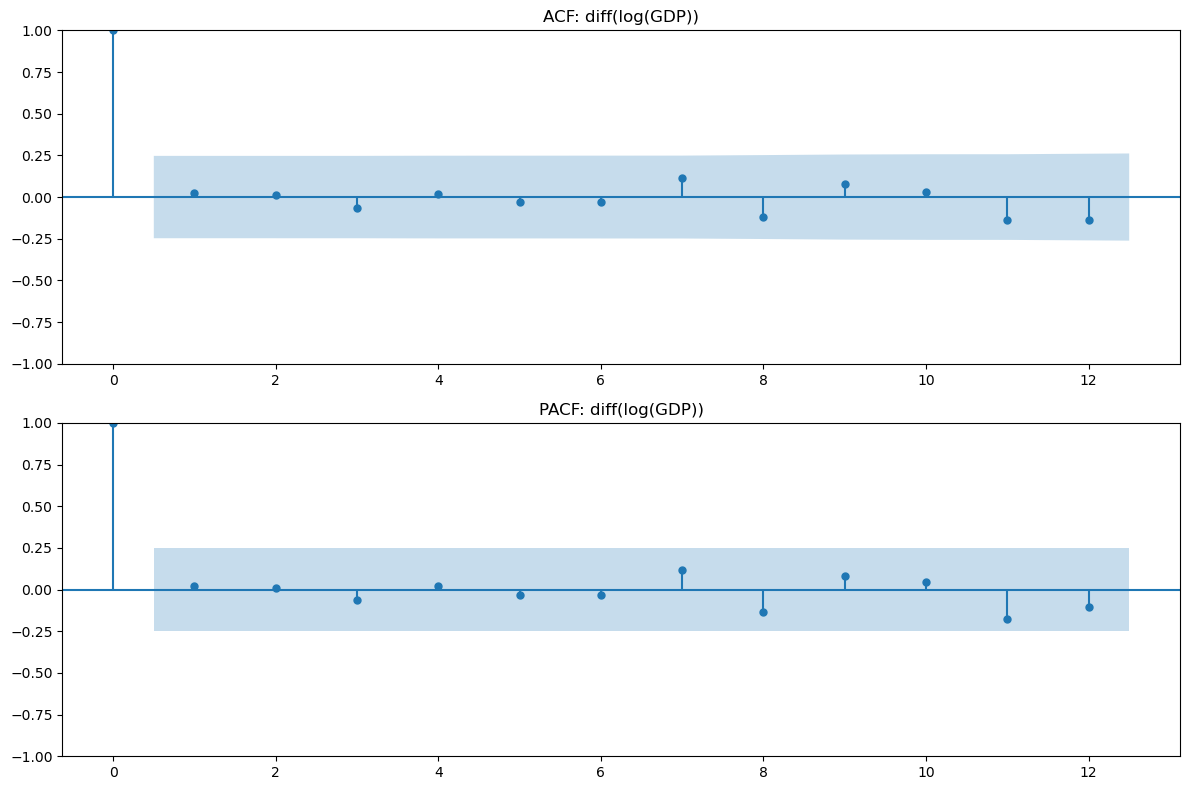

In [12]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(gdp_log_diff, lags=12, ax=ax1)
ax1.set_title("ACF: diff(log(GDP))")

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(gdp_log_diff, lags=12, ax=ax2, method="ywm")
ax2.set_title("PACF: diff(log(GDP))")

plt.tight_layout()
plt.show()

### ACF and PACF Interpretation

The autocorrelation and partial autocorrelation functions of Δlog(GDP) show limited significant spikes beyond lag 0.

Most autocorrelations fall within the 95% confidence bands, suggesting weak remaining serial dependence.

This indicates that a relatively low-order ARMA structure may adequately capture the dynamics of GDP growth.

## 6. Train/test split

For a simple validation, we hold out the final 10 observations as a test set.  
This is not a full forecasting competition setup, but it provides a sanity-check on out-of-sample performance.

In [13]:
test_size = 10
train = gdp.iloc[:-test_size]
test = gdp.iloc[-test_size:]

train.index.min(), train.index.max(), test.index.min(), test.index.max(), (train.shape, test.shape)

(Timestamp('1960-01-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2023-01-01 00:00:00'),
 ((54,), (10,)))

## 7. Model selection (parsimonious grid)

We evaluate a small grid of ARIMA(p, d, q) models on the **level GDP** series using a holdout split.

Notes:
- GDP in levels typically needs differencing (d >= 1).  
- We keep the grid small for clarity and reproducibility.

We select the model with the lowest RMSE on the test set.

In [14]:
from itertools import product

# Small, transparent grid (you can expand if needed)
p_vals = [0, 1, 2, 3]
d_vals = [1, 2]
q_vals = [0, 1, 2, 3]

candidates = list(product(p_vals, d_vals, q_vals))

results = []
for order in candidates:
    try:
        model = ARIMA(train, order=order).fit()
        pred = model.predict(start=test.index[0], end=test.index[-1])
        rmse = float(np.sqrt(mean_squared_error(test, pred)))
        results.append((order, rmse, model.aic, model.bic))
    except Exception:
        continue

grid = pd.DataFrame(results, columns=["order", "rmse", "aic", "bic"]).sort_values("rmse").reset_index(drop=True)
grid.head(10)

c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

,order,rmse,aic,bic
0,"(3, 2, 1)",356.461566,572.959950,582.716168
1,"(1, 2, 3)",386.763446,576.543450,586.299669
2,"(3, 2, 0)",390.045067,571.182720,578.987695
3,"(3, 2, 2)",390.995329,573.445050,585.152513
4,"(2, 2, 1)",394.802108,572.376927,580.181902
5,"(2, 2, 3)",402.199735,572.674299,584.381761
6,"(1, 2, 2)",405.831328,575.469103,583.274078
7,"(0, 2, 1)",436.462645,575.149330,579.051817
8,"(1, 2, 1)",441.838814,576.967634,582.821365
9,"(0, 2, 2)",449.238916,576.620739,582.474470


### Model Selection Results

The grid search compares ARIMA specifications based on:

- RMSE (forecast accuracy on holdout sample)
- AIC and BIC (in-sample fit with penalty for complexity)

The best-performing model by RMSE is:

ARIMA(3, 2, 1)  
RMSE ≈ 356  

This model balances predictive accuracy with model parsimony and is selected for further evaluation.

## 8. Fit the selected model and evaluate

We fit the best-performing (lowest RMSE) specification on the training set and evaluate predictions on the test period.

In [15]:
best_order = tuple(grid.loc[0, "order"])
best_order

(3, 2, 1)

### Fit and predict (holdout)

We compare fitted predictions against the held-out observations.

In [16]:
best_model = ARIMA(train, order=best_order).fit()

pred_test = best_model.predict(start=test.index[0], end=test.index[-1])
rmse = float(np.sqrt(mean_squared_error(test, pred_test)))

rmse

c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


356.4615658324

### Plot: train, test, and predictions

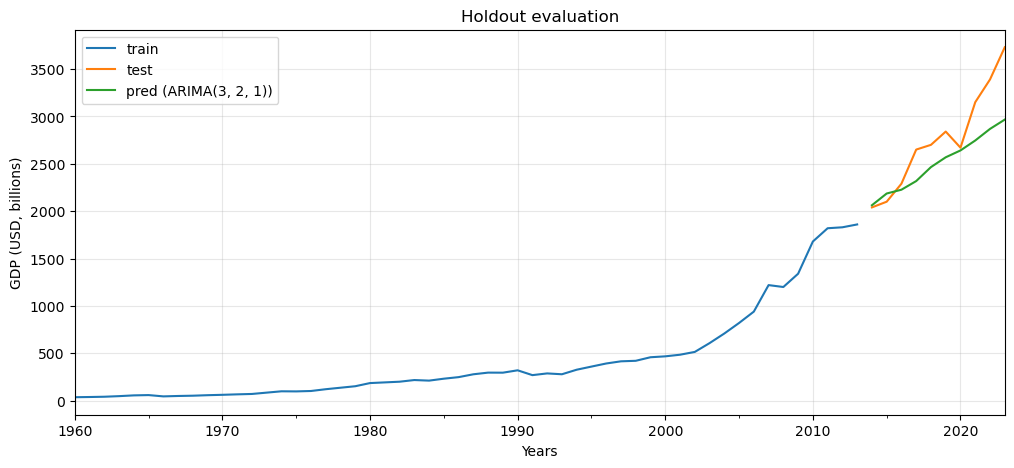

In [17]:
plt.figure(figsize=(12,5))
train.plot(label="train")
test.plot(label="test")
pred_test.plot(label=f"pred (ARIMA{best_order})")
plt.title("Holdout evaluation")
plt.ylabel("GDP (USD, billions)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### Holdout Performance

The ARIMA(3,2,1) model tracks the general upward trajectory of GDP during the test period.

While the model captures the broad trend, deviations occur during periods of rapid acceleration, reflecting the difficulty of forecasting structural growth shifts.

The RMSE of approximately 356 (USD billions) indicates moderate forecast error relative to the scale of GDP.

## 9. Residual diagnostics

A well-specified ARIMA model should leave residuals that resemble white noise.

We check:
- Residual time plot
- Residual ACF
- Ljung–Box test (null: no autocorrelation up to given lags)

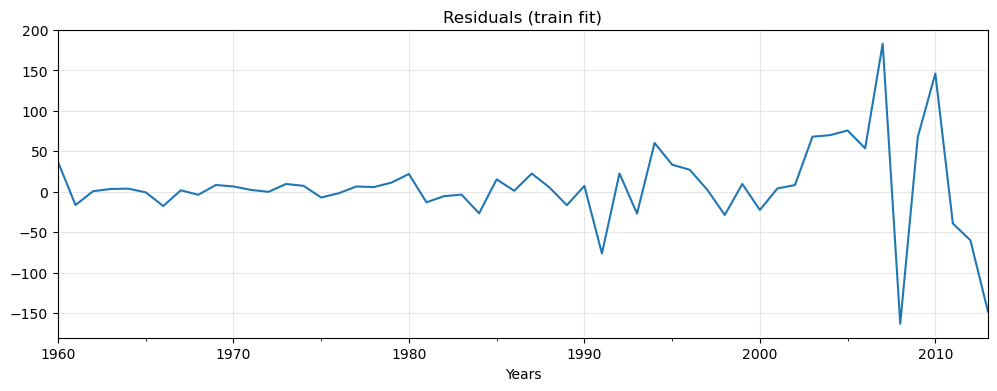

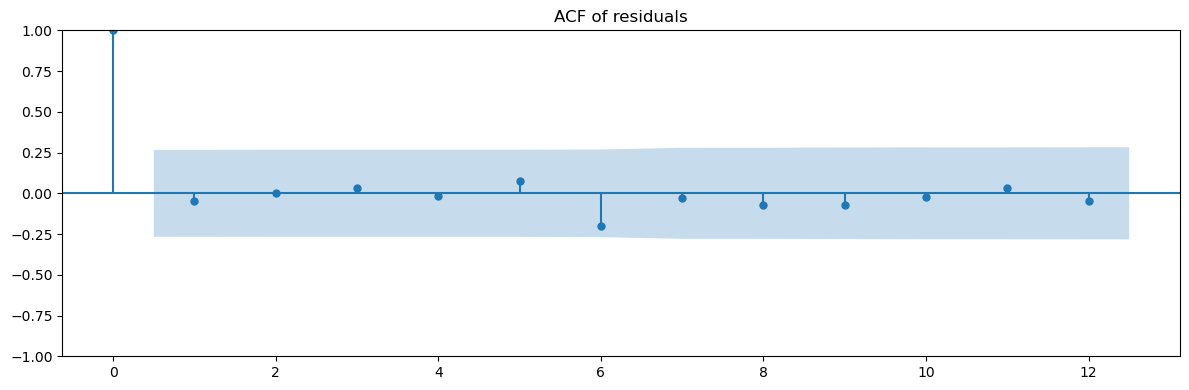

,lb_stat,lb_pvalue
10,3.767268,0.957236


In [18]:
resid = best_model.resid.dropna()

plt.figure(figsize=(12,4))
resid.plot()
plt.title("Residuals (train fit)")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12,4))
sm.graphics.tsa.plot_acf(resid, lags=12, ax=plt.gca())
plt.title("ACF of residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(resid, lags=[10], return_df=True)
lb

### Residual Diagnostics

The residual plot shows no clear systematic pattern.

The ACF of residuals displays no significant autocorrelation beyond lag 0.

Ljung–Box Test:
p-value ≈ 0.96

Since the p-value is well above 0.05, we fail to reject the null hypothesis that residuals are independently distributed.

Conclusion:
The residuals resemble white noise, suggesting the ARIMA(3,2,1) specification is adequately capturing the time-series structure.

## 10. Refit on full sample and forecast

After selecting a reasonable specification, we refit the model on the full GDP series and produce forecasts.

Forecasts are accompanied by 95% confidence intervals.

In [19]:
final_model = ARIMA(gdp, order=best_order).fit()

horizon = 16  # number of future periods
fc = final_model.get_forecast(steps=horizon)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

forecast_table = pd.DataFrame({
    "GDP_actual": gdp,
    "GDP_forecast": fc_mean,
    "lower_95": fc_ci.iloc[:, 0],
    "upper_95": fc_ci.iloc[:, 1],
})

forecast_table.tail(10)

c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


,GDP_actual,GDP_forecast,lower_95,upper_95
2030-01-01,NaN,4872.937355,4293.814934,5452.059777
2031-01-01,NaN,5102.821509,4445.334956,5760.308062
2032-01-01,NaN,5290.554414,4548.135022,6032.973806
2033-01-01,NaN,5493.933646,4663.356307,6324.510986
2034-01-01,NaN,5662.459318,4733.900145,6591.018491
2035-01-01,NaN,5861.101359,4834.340328,6887.862390
2036-01-01,NaN,6049.677358,4921.401025,7177.953691
2037-01-01,NaN,6251.364130,5020.288070,7482.440190
2038-01-01,NaN,6435.777479,5096.596067,7774.958890
2039-01-01,NaN,6628.335024,5178.316639,8078.353409


### Forecast Interpretation (2030–2039)

The model forecasts continued growth in GDP over the projection horizon.

Key observations:

- Forecasted GDP increases steadily each year.
- Confidence intervals widen over time, reflecting increasing uncertainty.
- The upper and lower bounds diverge substantially by the end of the horizon.

This widening interval is consistent with time-series forecasting theory: uncertainty compounds as the forecast horizon extends.

### Plot: historical GDP and forecasts

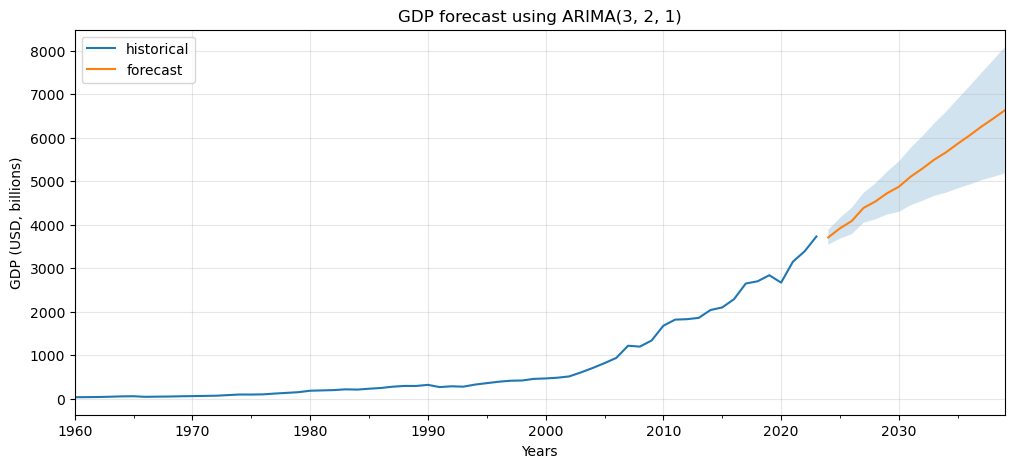

In [20]:
plt.figure(figsize=(12,5))
gdp.plot(label="historical")
fc_mean.plot(label="forecast")
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.2)
plt.title(f"GDP forecast using ARIMA{best_order}")
plt.ylabel("GDP (USD, billions)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### Long-Run Forecast Dynamics

The forecast suggests persistent growth momentum in GDP.

However, the expanding confidence band highlights an important limitation:

ARIMA models extrapolate historical dynamics and cannot anticipate structural breaks, policy shocks, or external macroeconomic disruptions.

Therefore, long-horizon forecasts should be interpreted cautiously.

## 11. Save outputs

We export the forecast table to the repository `data/` folder for easy reuse (e.g., in a report or README).

In [21]:
OUT_PATH = Path("..") / "data" / "results.csv"
forecast_table.to_csv(OUT_PATH, index=True)
OUT_PATH

WindowsPath('../data/results.csv')

# Final Conclusions

This analysis examined the time-series properties of GDP using the Box–Jenkins ARIMA framework.

Key findings:

1. GDP in levels is non-stationary.
2. The growth rate of GDP (Δlog(GDP)) is stationary.
3. ARIMA(3,2,1) provides the best holdout performance among candidate models.
4. Residual diagnostics confirm adequate model specification.
5. Forecasts indicate continued growth with increasing uncertainty over time.

Econometric Implication:

GDP follows a highly persistent stochastic process consistent with integrated macroeconomic aggregates. Short-run dynamics can be modeled effectively using ARIMA, but long-run forecasts remain sensitive to structural change.

This univariate analysis provides a benchmark framework before extending to multivariate approaches such as VAR modeling.